In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
import os
%matplotlib inline

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In order to increase the size of the training data each ROI was possibly included multiple times - with different zooms and margins, and also with random rotations and crops. At first I had just combined all of the images, shuffled them and then split them into training and test data, but I realized that including versions of the same images in both the training and test sets would make the test results worthless.

The CBIS-DDSM data was already divided into training and test sets, so I decided the easiest way to segregate the data was to keep the existing division. This requires splitting the normal DDSM images up in such a way as to keep the proportions balanced, while maintaining the same general class distribution.

In reality, about 90% of mammograms are normal. In order to maximize recall I decided to weight my dataset a bit more heavily towards abnormal images. My target is 85% normal.

In [2]:
# load the data
train_cbis_slices = np.load(os.path.join("data", "cbis_train_slices.npy"))
train_cbis_labels = np.load(os.path.join("data", "cbis_train_labels.npy"))
train_cbis_filenames = np.load(os.path.join("data", "cbis_train_names.npy"))

test_cbis_slices = np.load(os.path.join("data", "cbis_test_slices.npy"))
test_cbis_labels = np.load(os.path.join("data", "cbis_test_labels.npy"))
test_cbis_filenames = np.load(os.path.join("data", "cbis_test_names.npy"))

normal_slices_0 = np.load(os.path.join("data", "lumisys_slices.npy"))
normal_labels_0 = np.load(os.path.join("data", "lumisys_labels.npy"))

normal_slices_1 = np.load(os.path.join("data", "howtek_slices.npy"))
normal_labels_1 = np.load(os.path.join("data", "howtek_labels.npy"))

normal_slices_2 = np.load(os.path.join("data", "dba_slices.npy"))
normal_labels_2 = np.load(os.path.join("data", "dba_labels.npy"))

num_normal_images = len(normal_slices_0) + len(normal_slices_1) + len(normal_slices_2) #+ len(normal_slices_3) + len(normal_slices_4)
normal_filenames = np.repeat("NORMAL", num_normal_images)

# concatenate the data
all_normal_images = np.concatenate([normal_slices_0, normal_slices_1, normal_slices_2], axis=0)
all_normal_labels = np.concatenate([normal_labels_0, normal_labels_1, normal_labels_2], axis=0)

# import the mias data
mias_images = np.load(os.path.join("data", "all_mias_slices.npy"))
mias_labels = np.load(os.path.join("data", "all_mias_labels.npy"))
mias_filenames = np.load(os.path.join("data", "all_mias_filenames.npy"))

print("MIAS Images", mias_images.shape)
print("CBIS Train Images:", train_cbis_slices.shape)
print("CBIS Test Images:", test_cbis_slices.shape)
print("Normal Images:", all_normal_images.shape)

MIAS Images (2211, 299, 299, 1)
CBIS Train Images: (10191, 299, 299, 1)
CBIS Test Images: (2569, 299, 299, 1)
Normal Images: (65827, 299, 299, 1)


In [3]:
# delete some variables to save memory
del(normal_slices_0, normal_slices_1, normal_slices_2)#, normal_slices_3, normal_slices_4)
del(normal_labels_0, normal_labels_1, normal_labels_2)#, normal_labels_3, normal_labels_4)

In [8]:
# in reality about 10% of mammograms are abnormal. Since I want to maximize recall I want my dataset to be skewed towards
# having slightly more abnormal images. I need to divide the normal images up between the training and testing datasets
# trying to keep the distribution within a certain range.
total_cbis_images = train_cbis_slices.shape[0] + test_cbis_slices.shape[0]
cbis_percent_train = train_cbis_slices.shape[0] / total_cbis_images
total_normal_images = all_normal_images.shape[0]

# our minimum percentage of normal images is 20%
min_normal_data_size = total_cbis_images // 0.20
min_normal_train_images = min_normal_data_size * cbis_percent_train
min_normal_test_images = min_normal_data_size * (1 - cbis_percent_train)

# our maximum number of normal images
max_number_train_normal_images = total_normal_images * cbis_percent_train
max_number_test_normal_images = total_normal_images - max_number_train_normal_images

# the min of these two sets will be the actual number of normal images we use for each dataset
target_number_train_normal_images = int(np.max([max_number_train_normal_images, min_normal_train_images]))
target_number_test_normal_images = int(np.max([max_number_test_normal_images, min_normal_test_images]))

print("Target Train Normal Images:", target_number_train_normal_images)
print("Target Test Normal Images:", target_number_test_normal_images)
print("Target Total Normal Size:", target_number_train_normal_images + target_number_test_normal_images)

print("Train Distribution:", train_cbis_slices.shape[0] / (target_number_train_normal_images + train_cbis_slices.shape[0]))
print("Test Distribution:", test_cbis_slices.shape[0] / (target_number_test_normal_images + test_cbis_slices.shape[0]))

Target Train Normal Images: 52573
Target Test Normal Images: 13253
Target Total Normal Size: 65826
Train Distribution: 0.16237014849276654
Test Distribution: 0.16236885349513336


In [11]:
# shuffle the data
all_normal_images, all_normal_labels, normal_filenames = shuffle(all_normal_images, all_normal_labels, normal_filenames, random_state=101)

# then take the appropriate number of rows
train_normal_images = all_normal_images[:target_number_train_normal_images,:,:,:]
train_normal_labels = all_normal_labels[:target_number_train_normal_images]
train_normal_filenames = normal_filenames[:target_number_train_normal_images]

test_normal_images = all_normal_images[target_number_train_normal_images:target_number_train_normal_images+target_number_test_normal_images,:,:,:]
test_normal_labels = all_normal_labels[target_number_train_normal_images:target_number_train_normal_images+target_number_test_normal_images]
test_normal_filenames = normal_filenames[target_number_train_normal_images:target_number_train_normal_images+target_number_test_normal_images]

print("Train Normal Images:", train_normal_images.shape)
print("Train Normal Labels:", train_normal_labels.shape)

print("Test Normal Images:", test_normal_images.shape)
print("Test Normal Labels:", test_normal_labels.shape)

Train Normal Images: (52573, 299, 299, 1)
Train Normal Labels: (52573,)
Test Normal Images: (13253, 299, 299, 1)
Test Normal Labels: (13253,)


In [12]:
# concatenate the ddsm and cbis data
# currently I am not including the MIAS data in my dataset
train_images = np.concatenate([train_cbis_slices, train_normal_images], axis=0) # , mias_images
train_labels = np.concatenate([train_cbis_labels, train_normal_labels], axis=0) # , mias_labels
train_filenames = np.concatenate([train_cbis_filenames, train_normal_filenames]) # , mias_filenames

print("Train images:", train_images.shape)
print("Train labels:", train_labels.shape)
print("Train filenames:", train_filenames.shape)

Train images: (62764, 299, 299, 1)
Train labels: (62764,)
Train filenames: (62764,)


In [13]:
# delete old variables
del(train_cbis_slices, train_normal_images, mias_images)
del(train_cbis_labels, train_normal_labels)

In [14]:
# create the test data
test_images = np.concatenate([test_cbis_slices, test_normal_images], axis=0)
test_labels = np.concatenate([test_cbis_labels, test_normal_labels], axis=0)
test_filenames = np.concatenate([test_cbis_filenames, test_normal_filenames])

print("Test images:", test_images.shape)
print("Test labels:", test_labels.shape)
print("Test filenames:", test_filenames.shape)

Test images: (15822, 299, 299, 1)
Test labels: (15822,)
Test filenames: (15822,)


In [15]:
# delete old vars
del(test_cbis_slices, test_normal_images)

In [16]:
# encode the labels
le = preprocessing.LabelEncoder()
le.fit(train_labels)
# we want normal to be 0, so we'll do some transformations here
train_labels_enc = le.transform(train_labels) + 1
train_labels_enc[train_labels_enc == 5] = 0

# encode the test labels
test_labels_enc = le.transform(test_labels) + 1
test_labels_enc[test_labels_enc == 5] = 0

# make the classes be in the same order as the labels
classes = le.classes_
classes = np.insert(classes, 0, 'NORMAL', axis=0)
classes = classes[0:5]

# make some other labels
labels_normal = np.zeros(len(train_labels_enc)).astype(np.int32)
labels_normal[train_labels_enc != 0] = 1

labels_mass = np.zeros(len(train_labels_enc)).astype(np.int32)
labels_mass[train_labels_enc == 1] = 1
labels_mass[train_labels_enc == 3] = 1
labels_mass[train_labels_enc == 2] = 2
labels_mass[train_labels_enc == 4] = 2

labels_benign = np.zeros(len(train_labels_enc)).astype(np.int32)
labels_benign[train_labels_enc == 1] = 1
labels_benign[train_labels_enc == 2] = 1
labels_benign[train_labels_enc == 3] = 2
labels_benign[train_labels_enc == 4] = 2

np.save(os.path.join("data", "all_classes.npy"), classes)

In [17]:
# encode the mias labels
mias_labels_enc = le.transform(mias_labels) + 1
mias_labels_enc[mias_labels_enc == 5] = 0

# save the encoded labels
np.save(os.path.join("data", "mias_test_labels_enc.npy"), mias_labels_enc)

### Check the distribution of the training data

In [18]:
pd.value_counts(labels_benign, normalize=True)

0    0.837630
2    0.087343
1    0.075027
dtype: float64

In [19]:
pd.value_counts(labels_mass, normalize=True)

0    0.837630
1    0.100503
2    0.061867
dtype: float64

In [20]:
pd.value_counts(labels_normal, normalize=True)

0    0.83763
1    0.16237
dtype: float64

## Shuffle the data and split it

In [21]:
from sklearn.model_selection import train_test_split

# shuffle the training data
X_tr, y_tr, train_filenames, labels_normal, labels_mass, labels_benign = shuffle(train_images, train_labels_enc, train_filenames, labels_normal, labels_mass, labels_benign, random_state=7241972)

# split test into test and validation
X_te, X_cv, y_te, y_cv, test_filenames, cv_filenames = train_test_split(test_images, test_labels_enc, test_filenames, test_size=0.5, random_state=228859)

print("X_tr", X_tr.shape)
print("X_te", X_te.shape)
print("X_cv", X_cv.shape)

X_tr (62764, 299, 299, 1)
X_te (7911, 299, 299, 1)
X_cv (7911, 299, 299, 1)


### Check the distribution of the test data

In [22]:
pd.value_counts(y_te, normalize=True)

0    0.835166
3    0.053975
1    0.040071
2    0.039944
4    0.030843
dtype: float64

In [23]:
pd.value_counts(y_cv, normalize=True)

0    0.840096
3    0.054481
2    0.042346
1    0.035394
4    0.027683
dtype: float64

In [24]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [25]:
# write train data to tfrecords in 5 batches
import math
num_batches = 5
batch_size = math.ceil(X_tr.shape[0] / num_batches)

for i in range(num_batches):
    train_path = os.path.join("data","training6_" + str(i) + '.tfrecords')
    writer = tf.python_io.TFRecordWriter(train_path)
    start_row = i * batch_size
    end_row = start_row + batch_size - 1
                              
    for idx in range(start_row, end_row):
        # try to get the data, if there is an error skip this index
        try:
            label = y_tr[idx]
            label_normal = labels_normal[idx]
            label_mass = labels_mass[idx]
            label_benign = labels_benign[idx]
            filename = train_filenames[idx].tostring()
            image = X_tr[idx]
            image_raw = image.tostring()
        except:
            continue
            
        example = tf.train.Example(
            features=tf.train.Features(
              feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'label': _int64_feature(label),
                'label_normal': _int64_feature(label_normal),
                'filename': _bytes_feature(filename),
                'label_mass': _int64_feature(label_mass),
                'label_benign': _int64_feature(label_benign),
                'image': _bytes_feature(image_raw),
              }))

        # use the proto object to serialize the example to a string
        serialized = example.SerializeToString()
        # write the serialized object to disk
        writer.write(serialized)

In [26]:
# save the test data and labels to npy files
print("X_te:", X_te.shape)
test_batch_size = X_te.shape[0] // 2
print("Test batch size:", test_batch_size)

X_te: (7911, 299, 299, 1)
Test batch size: 3955


In [27]:
## save the test data
np.save(os.path.join("data", "test6_data.npy"), X_te)
np.save(os.path.join("data", "test6_labels.npy"), y_te)
np.save(os.path.join("data", "test6_filenames.npy"), test_filenames)

In [28]:
# save the validation data
np.save(os.path.join("data", "cv6_data.npy"), X_cv)
np.save(os.path.join("data", "cv6_labels.npy"), y_cv)
np.save(os.path.join("data", "cv6_filenames.npy"), cv_filenames)

## Verify that the data was written correctly

In [2]:
# make sure everything was written properly by reading it back out
def read_and_decode_single_example(filenames):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string)
        })
    
    # now return the converted data
    label = features['label']
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])
    
    # scale the image
    image = tf.image.per_image_standardization(image)
    
    # random flip image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    #image = tf.image.random_brightness(image, max_delta=10)
    #image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    
    return label, image

In [3]:
label, image = read_and_decode_single_example(["data/training6_0.tfrecords", "data/training6_1.tfrecords"])

#images_batch, labels_batch = tf.train.shuffle_batch([image, label], batch_size=16, capacity=2000, min_after_dequeue=1000)
images_batch, labels_batch = tf.train.batch([image, label], batch_size=16, capacity=2000)

global_step = tf.Variable(0, trainable=False)

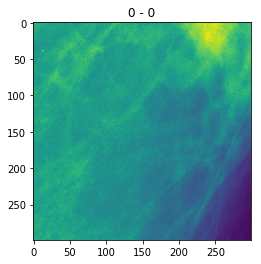

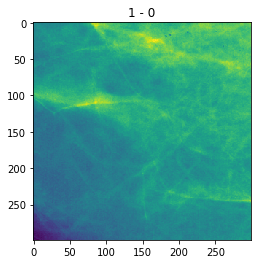

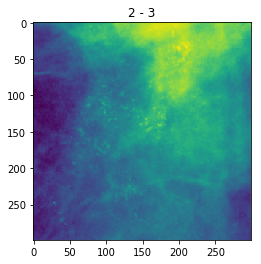

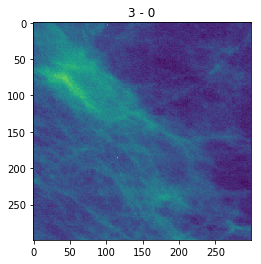

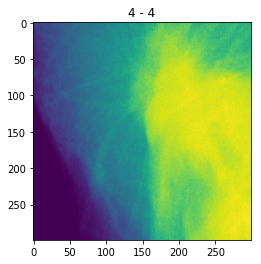

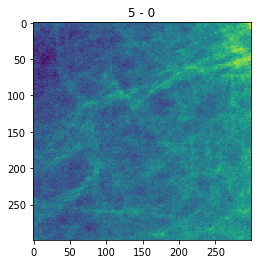

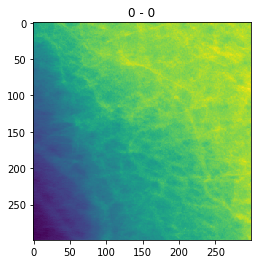

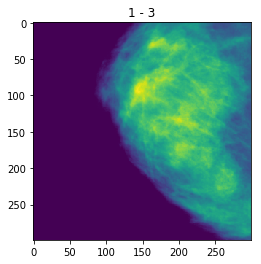

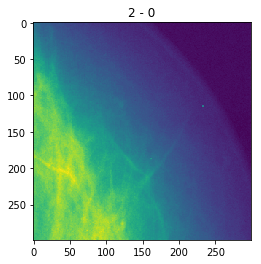

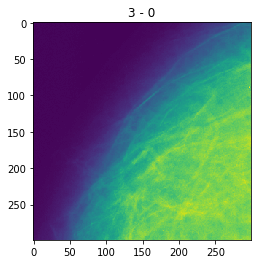

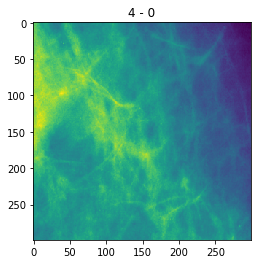

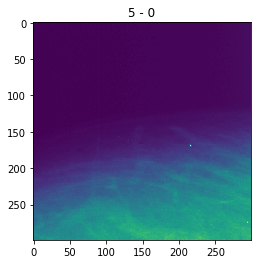

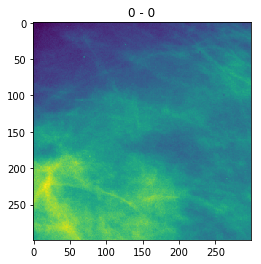

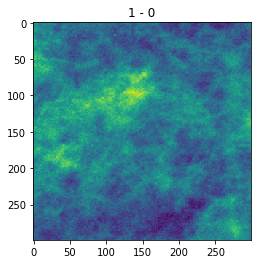

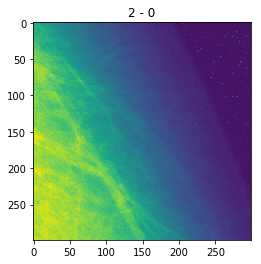

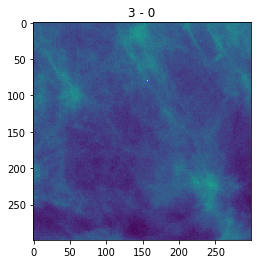

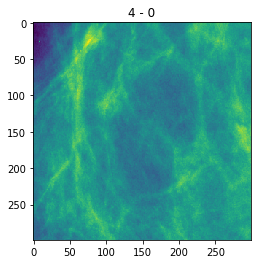

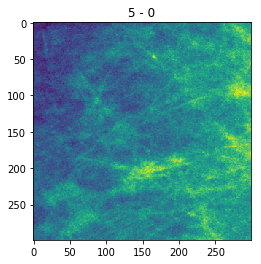

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for j in range(3):
        la_b, im_b = sess.run([labels_batch, images_batch])

        for i in range(6):
            plt.imshow(im_b[i].reshape([299,299]))
            plt.title(str(i) + " - " + str(la_b[i]))
            plt.show()

    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)